In [1]:
!pip install processmcrat

In [19]:
%matplotlib notebook
import processmcrat as pm
import astropy.units as unit
from astropy import constants as const
import matplotlib.pyplot as plt
import numpy as np

"""
Notebook attempting to retrieve the Goodman spectrum from a spherical outflow simulation.

PLUTO CHOMBO HD frames, with angles 0-20 degrees, 3 angle bins
"""

In [27]:
mcrat_sim=pm.McratSimLoad("/Users/josearita-escalante/Documents/GRB-NASA/MCRaT-gits/MCRaT-resolution/CHOMBO/spherical-outflow/big-angle/2638/") 
mcrat_sim.load_frame(2638, read_stokes=False)
observation=pm.MockObservation(1, 30, 1e14, 5, mcratsimload_obj=mcrat_sim)

In [28]:
lis=observation.detected_photons.detection_time
lis.sort()
print(min(lis),",",max(lis))

6.355234133029171 , 146.5994095072674


In [29]:
observation.set_spectral_fit_parameters()
spectrum_dict=observation.spectrum(5, 151,spectrum_unit=unit.count/unit.s/unit.keV, 
                                     fit_spectrum=True,sample_num=1e4)

lightcurve_dict=observation.lightcurve(time_start=5, time_end=151, dt=0.2)

<IPython.core.display.Javascript object>


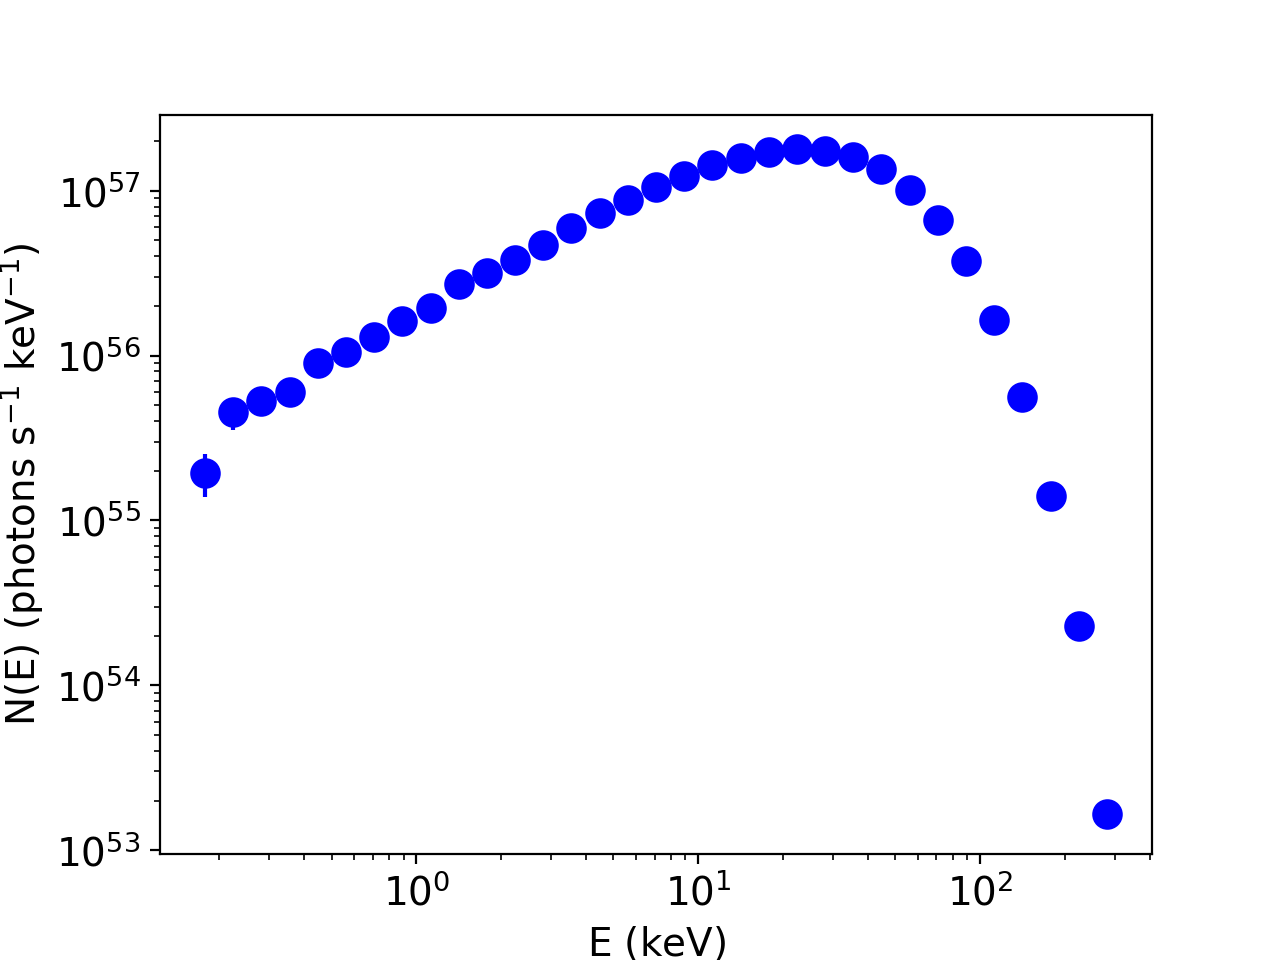

In [30]:
#plot the MCRaT spectrum
f, ax=pm.plot_spectrum(spectrum_dict)

<ipython-input-31-5ad0fa2341b5>:28: RuntimeWarning: overflow encountered in exp
  model=(energies**3/(const.h.cgs.value*const.c.cgs.value)**2)/(np.exp(energies/(const.k_B.cgs.value*temp))-1)


<IPython.core.display.Javascript object>


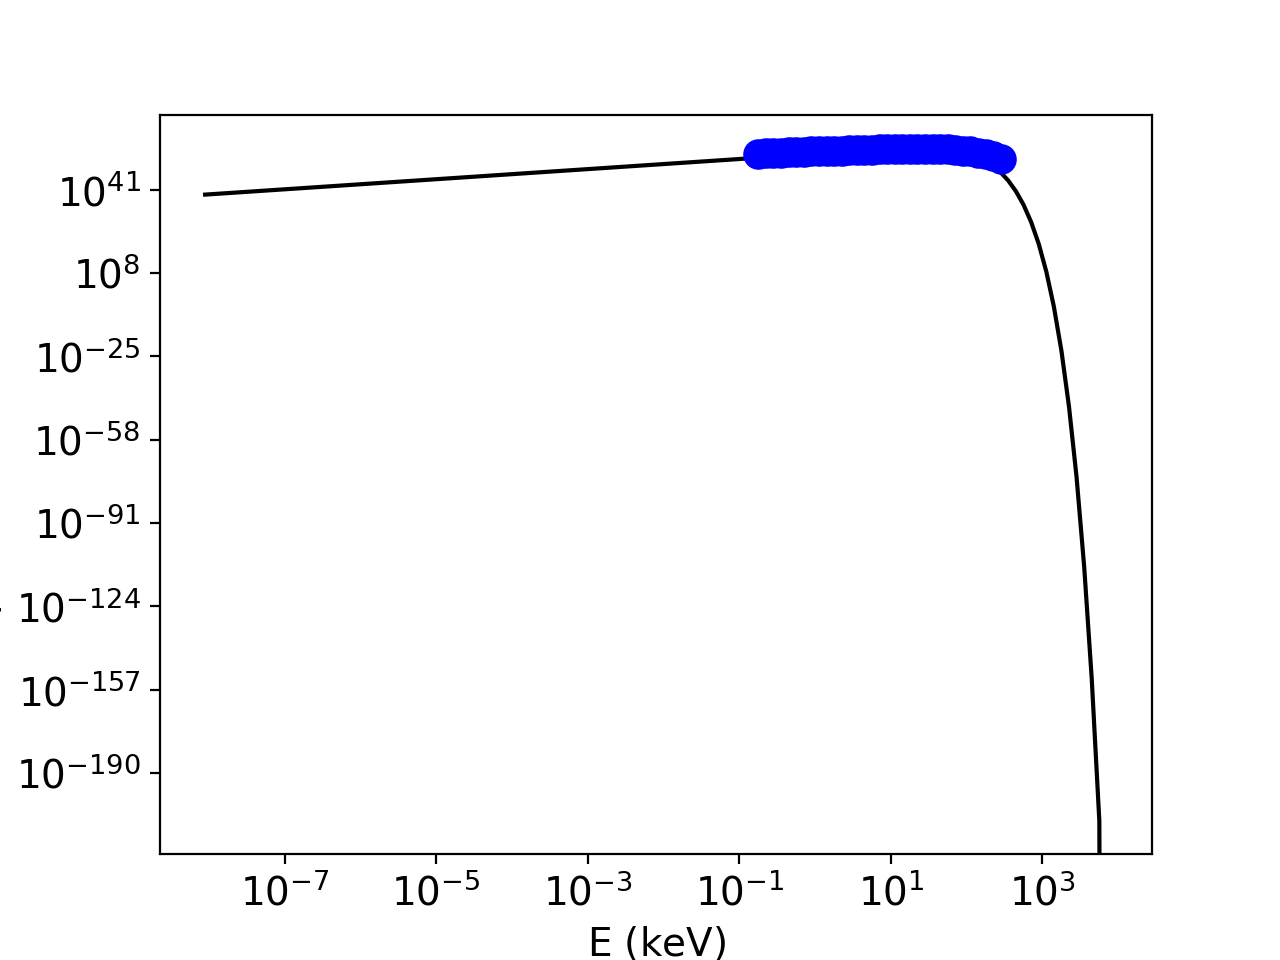

In [31]:
def blackbody_function(energies, temp, normalization, energy_unit=unit.keV):
	"""
	:param energies:
	:param temp:
	:param normalization:
	:param energy_unit:
	:return:
	"""

	energies=energies*energy_unit.to(unit.erg)
	try:
		energies=energies.value
	except AttributeError:
		energies = energies

	try:
		temp=temp.value
	except AttributeError:
		temp = temp
  
	try:
		normalization=normalization.value
	except AttributeError:
		normalization = normalization


	model =np.empty(energies.size)
	model=(energies**3/(const.h.cgs.value*const.c.cgs.value)**2)/(np.exp(energies/(const.k_B.cgs.value*temp))-1)
	energies = energies * unit.erg.to(energy_unit)
	model=model/np.trapz(model,x=energies)*normalization

	return model

data=blackbody_function(spectrum_dict['energy_bin_center'], 1.3e9, np.trapz(spectrum_dict['spectrum'], x=spectrum_dict['energy_bin_center']))

factor_x=(spectrum_dict['energy_bin_center'][data.argmax()]/spectrum_dict['energy_bin_center'][spectrum_dict['spectrum'].argmax()])**-1

f, ax=pm.plot_spectrum(spectrum_dict)
ax.plot(spectrum_dict['energy_bin_center']*factor_x, data*spectrum_dict['spectrum'].max()/data.max(), 'k-')

<IPython.core.display.Javascript object>


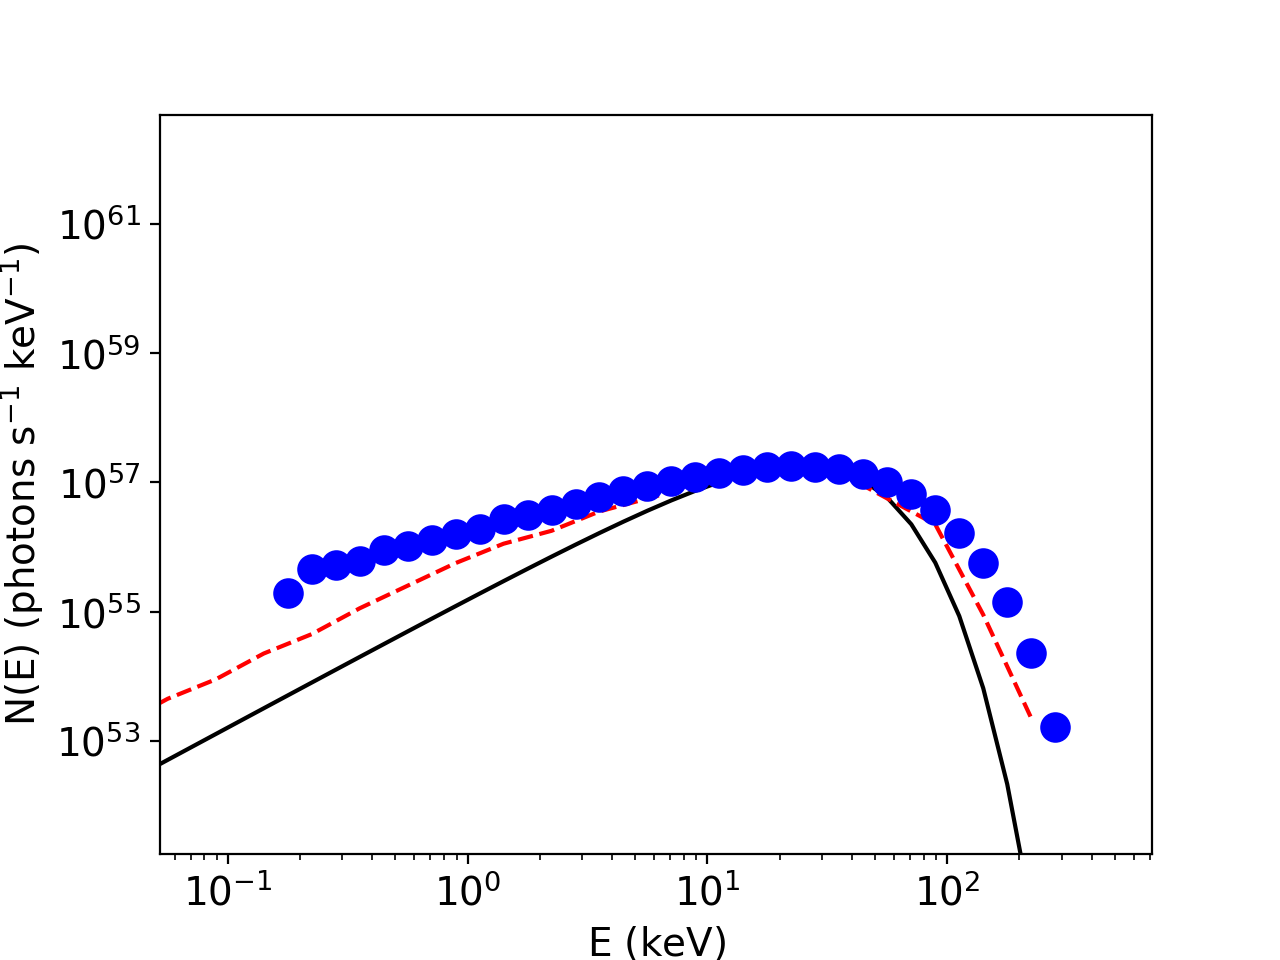

In [32]:
def goodman_function(energy_maximum, spectrum_maximum):
	"""
	Function that returns Goodman's scalable spherical explosion spectra to compare against a spectra acquired by a
	spherical explosion run in MCRAT. To compare this to simulation data, the simulation spectrum needs to be in units
	of erg/s/energy_unit.
	:param energy_maximum:
	:param spectrum_maximum:
	:return:
	"""

	goodman_energy=10**np.array([-3,-2.8,-2.6,-2.4,-2.2,-2,-1.8,-1.6,-1.4,-1.2,-1,-.8,-.6,-.4,-.2,0,.2,.4,.6,.8,1.,1.2,1.4])
	goodman_spectrum=10**np.array([-5.2,-4.8,-4.5,-4.1,-3.7,-3.4,-3,-2.7,-2.3,-1.95,-1.6,-1.3,-1.1,-0.8,-0.6,-0.4,-0.2,-0.1,-0.2,-0.6,-1,-2.4,-4])

	y_shift=spectrum_maximum/goodman_spectrum.max()
	x_shift=energy_maximum/goodman_energy[goodman_spectrum.argmax()]

	goodman_spectrum_shift=goodman_spectrum*y_shift
	goodman_energy_shift=goodman_energy*x_shift

	return goodman_energy_shift, goodman_spectrum_shift

goodman=goodman_function(spectrum_dict['energy_bin_center'][spectrum_dict['spectrum'].argmax()], spectrum_dict['spectrum'].max())
f, ax=pm.plot_spectrum(spectrum_dict)
ax.plot(spectrum_dict['energy_bin_center']*factor_x, data*spectrum_dict['spectrum'].max()/data.max(), 'k-')
ax.plot(goodman[0], goodman[1], 'r--')

In [15]:
a=observation.detected_photons.scatterings
a.sort()
a

array([ 964.,  966., 1025., ..., 3726., 3733., 3743.])